In [1]:
import os
from sqlalchemy import create_engine,  MetaData
import pandas as pd
import cProfile

from cities.utils.data_grabber import (find_repo_root, DataGrabberCSV, MSADataGrabberCSV,
                                       list_available_features, list_csvs, DataGrabberDB )
import time 
import logging


import matplotlib.pyplot as plt

logging.disable(logging.WARNING)

root = find_repo_root()

database_paths = {
    'counties': os.path.join(root, "data/sql/counties_database.db"),
    'msa': os.path.join(root, "data/sql/msa_database.db"),
}

data_dirs = {
    "counties": os.path.join(root, "data/processed"),
    "msa": os.path.join(root, "data/MSA_level"),
}

features_counties = list_available_features()
features_msa = list_available_features("msa")

levels = ["counties", "msa"]


#features = {'counties': features_counties, 'msa': features_msa}[level]


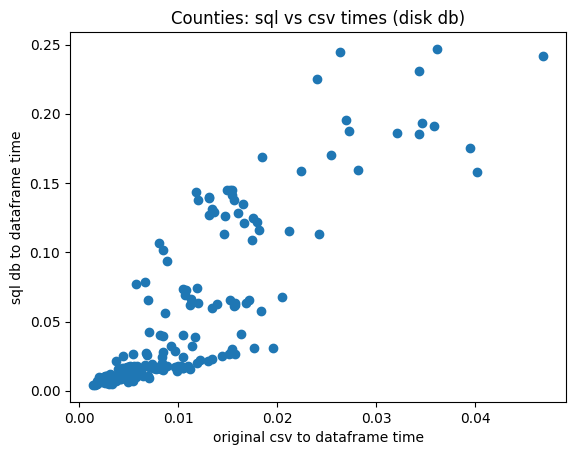

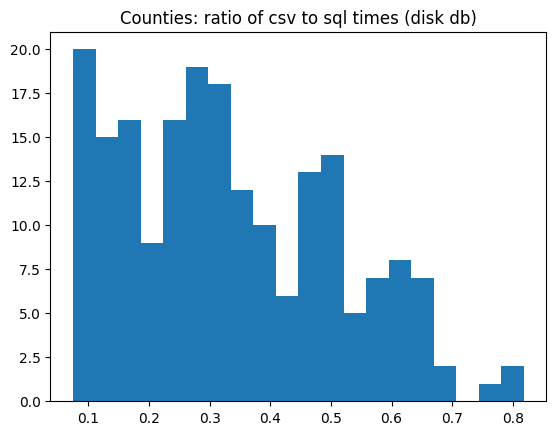

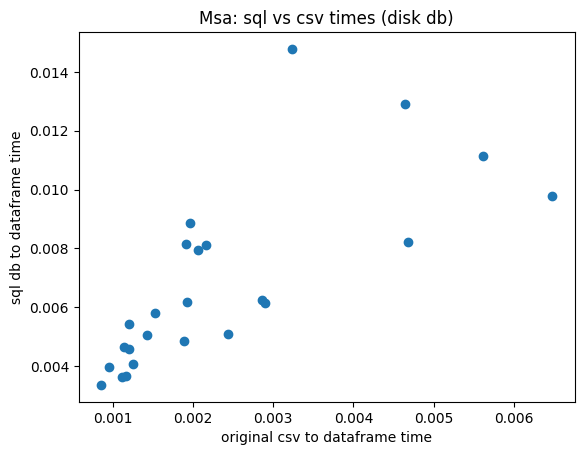

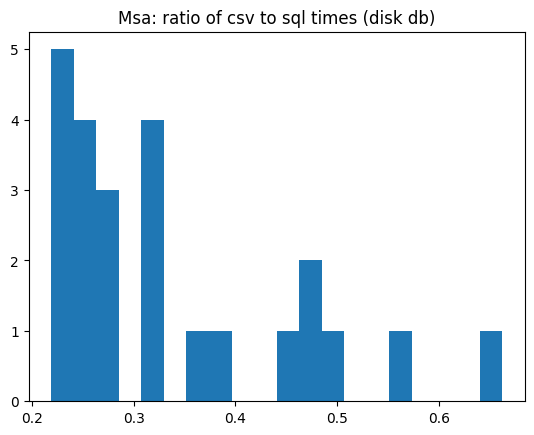

In [2]:
#level = 'counties'

for level in levels:

    database_path = database_paths[level]
    data_dir = data_dirs[level]
    csv_list = list_csvs(data_dir)


    engine = create_engine(f'sqlite:///{database_path}', echo=True)
    metadata = MetaData()
    metadata.reflect(bind=engine)
    table_names = metadata.tables.keys()

    sql_times = []
    df_times = []
    for csv in csv_list:
        assert csv[:-4] in table_names
        sql_start = time.time()
        df_from_sql = pd.read_sql_table(csv[:-4], con=engine)
        sql_end = time.time()
        sql_times.append(sql_end - sql_start)
        df_start = time.time()
        df_from_csv = pd.read_csv(os.path.join(data_dir, csv))
        df_end = time.time()
        df_times.append(df_end - df_start)
        assert df_from_sql.equals(df_from_csv)

    plt.scatter(x = df_times, y = sql_times)
    plt.xlabel("original csv to dataframe time")
    plt.ylabel("sql db to dataframe time")
    plt.title(f"{level.capitalize()}: sql vs csv times (disk db)")
    plt.show()

    proportions =  [df / sql for df, sql in zip(df_times, sql_times)]
    plt.hist(proportions, bins = 20)
    plt.title(f"{level.capitalize()}: ratio of csv to sql times (disk db)")

    plt.show()


In [3]:
# speed test for grabbing all features with DataGrabberDB and DataGrabberCSV
for level in levels:

    features = {'counties': features_counties, 'msa': features_msa}[level]

    data_grabber_db = DataGrabberDB(level)
    data_grabber_csv = DataGrabberCSV() if level == 'counties' else MSADataGrabberCSV()

    start_dgdb = time.time()
    data_grabber_db.get_features_wide(features)
    data_grabber_db.get_features_std_wide(features)
    data_grabber_db.get_features_long(features)
    data_grabber_db.get_features_std_long(features)
    end_dgdb = time.time()

    start_dgcsv = time.time()
    data_grabber_csv.get_features_std_wide(features)
    data_grabber_csv.get_features_wide(features)
    data_grabber_csv.get_features_long(features)
    data_grabber_csv.get_features_std_long(features)
    end_dgcsv = time.time()

    print(f"DataGrabberDB time: {end_dgdb - start_dgdb}")
    print(f"DataGrabberCSV time: {end_dgcsv - start_dgcsv}")

    print(f"CSV is {round((end_dgdb - start_dgdb) / (end_dgcsv - start_dgcsv), 2)} times faster than SQL for {level} data")

DataGrabberDB time: 10.866931676864624
DataGrabberCSV time: 1.9022014141082764
CSV is 5.71 times faster than SQL for counties data
DataGrabberDB time: 0.2874462604522705
DataGrabberCSV time: 0.03559613227844238
CSV is 8.08 times faster than SQL for msa data


In [4]:
level  = 'counties'

features = {'counties': features_counties, 'msa': features_msa}[level]

feature = features[0]
# more details:

def csv_run():
    data_grabber_csv = DataGrabberCSV() if level == 'counties' else MSADataGrabberCSV()
    data_grabber_csv.get_features_wide([feature])

def db_run():
    data_grabber_db = DataGrabberDB(level)
    data_grabber_db.get_features_wide([feature])

profiler_csv = cProfile.Profile()
profiler_db = cProfile.Profile()

profiler_csv.enable()
csv_run()
profiler_csv.disable()

profiler_db.enable()
db_run()
profiler_db.disable()

print(f"CSV time for {feature}:")
profiler_csv.print_stats(sort='cumulative')

print(f"DB time for {feature}:")
profiler_db.print_stats(sort='cumulative')

CSV time for age_composition:
         2637 function calls (2599 primitive calls) in 0.009 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.009    0.004 interactiveshell.py:3514(run_code)
        2    0.000    0.000    0.009    0.004 {built-in method builtins.exec}
        1    0.000    0.000    0.009    0.009 856933116.py:8(csv_run)
        1    0.000    0.000    0.009    0.009 data_grabber.py:50(get_features_wide)
        1    0.000    0.000    0.009    0.009 data_grabber.py:33(_get_features)
        1    0.000    0.000    0.009    0.009 readers.py:848(read_csv)
        1    0.000    0.000    0.009    0.009 readers.py:574(_read)
        1    0.000    0.000    0.007    0.007 readers.py:1732(read)
        1    0.000    0.000    0.006    0.006 c_parser_wrapper.py:222(read)
        1    0.006    0.006    0.006    0.006 {method 'read_low_memory' of 'pandas._libs.parsers.TextReader' objects}
  